<a href="https://colab.research.google.com/github/rwanalramli/BigData-StockPrediction/blob/main/Amazon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# تثبيت pyspark
!pip install pyspark

# استيراد المكتبات
from pyspark.sql import SparkSession

# إنشاء Spark Session
spark = SparkSession.builder \
    .appName("AmazonStockAnalysis") \
    .getOrCreate()

print("✅ Spark is ready!")


✅ Spark is ready!


In [3]:
from google.colab import drive
import os
from pyspark.sql import SparkSession

# ربط Google Drive
drive.mount('/content/drive')

# إنشاء Spark Session
spark = SparkSession.builder.appName("AmazonStockAnalysis").getOrCreate()

folder_path = "/content/drive/MyDrive/AmazonData"

# قراءة كل ملفات CSV داخل الفولدر
df = spark.read.csv(
    os.path.join(folder_path, "*.csv"),
    header=True,
    inferSchema=True
)

# عرض أول 5 أسطر للتأكد
df.show(5)

# عدد الصفوف الكلي
print("Total rows:", df.count())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------+
|               date|               open|               high|                low|              close|          adj_close|    volume|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------+
|               NULL|               AMZN|               AMZN|               AMZN|               AMZN|               AMZN|      AMZN|
|1997-05-15 00:00:00|0.12187500298023224|              0.125|0.09635400027036667|0.09791699796915054|0.09791699796915054|1443120000|
|1997-05-16 00:00:00|0.09843800216913223|0.09895800054073334| 0.0854170024394989| 0.0864579975605011| 0.0864579975605011| 294000000|
|1997-05-19 00:00:00|0.08802100270986557|0.08854199945926666|0.0812499970

In [4]:
from pyspark.sql import functions as F

# إسقاط الصفوف الفارغة تمامًا
df = df.na.drop(how="any")

#  لإعادة التسمية
rename_map = {
    "date":"Date", "Date":"Date",
    "open":"Open","open|AMZN":"Open","Open":"Open",
    "high":"High","high|AMZN":"High","High":"High",
    "low":"Low","low|AMZN":"Low","Low":"Low",
    "close":"Close","close|AMZN":"Close","Close":"Close",
    "adj close":"Adj_Close","Adj Close":"Adj_Close","Adj_Close":"Adj_Close","adj_close":"Adj_Close",
    "volume":"Volume","volume|AMZN":"Volume","Volume":"Volume",
    "ticker":"Ticker","symbol":"Ticker","Symbol":"Ticker","Ticker":"Ticker"
}

for c in list(df.columns):
    key = c.strip()
    if key in rename_map and c != rename_map[key]:
        df = df.withColumnRenamed(c, rename_map[key])

# تحويل التاريخ (لو كان نص) إلى تاريخ
df = df.withColumn("Date", F.to_date("Date"))

# تحويل الأعمدة الرقمية إلى Double
num_cols = [c for c in ["Open","High","Low","Close","Adj_Close","Volume"] if c in df.columns]
for c in num_cols:
    df = df.withColumn(c, F.col(c).cast("double"))

# ترتيب الأعمدة النهائية (حسب المتوفّر)
final_cols = ["Date"] + [c for c in ["Open","High","Low","Close","Adj_Close","Volume","Ticker"] if c in df.columns]
df = df.select(*final_cols).orderBy("Date")

df.show(5)
print("Rows:", df.count(), "| Cols:", len(df.columns))


+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|      Date|               Open|               High|                Low|              Close|          Adj_Close|   Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|1997-05-15|0.12187500298023224|              0.125|0.09635400027036667|0.09791699796915054|0.09791699796915054|1.44312E9|
|1997-05-16|0.09843800216913223|0.09895800054073334| 0.0854170024394989| 0.0864579975605011| 0.0864579975605011|   2.94E8|
|1997-05-19|0.08802100270986557|0.08854199945926666|0.08124999701976776| 0.0854170024394989| 0.0854170024394989|1.22136E8|
|1997-05-20| 0.0864579975605011|0.08749999850988388|0.08177100121974945|0.08177100121974945|0.08177100121974945|1.09344E8|
|1997-05-21|0.08177100121974945|0.08229199796915054|0.06875000149011612|0.07135400176048279|0.07135400176048279|3.77064E8|
+----------+----

In [28]:
from pyspark.sql import functions as F

df.printSchema()
print("Rows:", df.count(), "| Cols:", len(df.columns))

# نطاق التواريخ وو عدد الأسهم (لو عمود Ticker)
date_min, date_max = df.select(F.min("Date"), F.max("Date")).first()
print("Date range:", date_min, "→", date_max)
if "Ticker" in df.columns:
    print("Tickers:", df.select("Ticker").distinct().count())

# إحصائيات وصفية للأعمدة الرقمية
num_cols = [c for c,t in df.dtypes if t in ("int","bigint","double","float") and c != "label"]
df.select(num_cols).describe().show()

# قيم مفقودة لكل عمود
na_counts = df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df.columns]).toPandas()
na_counts


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj_Close: double (nullable = true)
 |-- Volume: double (nullable = true)

Rows: 20177 | Cols: 7
Date range: 1997-05-15 → 2025-09-12
+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|summary|              Open|               High|                Low|             Close|         Adj_Close|             Volume|
+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|  count|             20177|              20177|              20177|             20177|             20177|              20177|
|   mean| 71.65917262258748|  72.48375084223434|  70.76036540243501| 71.64615558279509| 71.64615558279509| 9.52472917827229E7|
| stddev| 65.56741043050017|   66.3186410087

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "isnan(Date)" due to data type mismatch: Parameter 1 requires the ("DOUBLE" or "FLOAT") type, however "Date" has the type "DATE".;
'Aggregate [count(CASE WHEN (isnull(Date#143) OR isnan(Date#143)) THEN Date END) AS Date#8397, count(CASE WHEN (isnull(Open#151) OR isnan(Open#151)) THEN Open END) AS Open#8399L, count(CASE WHEN (isnull(High#159) OR isnan(High#159)) THEN High END) AS High#8401L, count(CASE WHEN (isnull(Low#167) OR isnan(Low#167)) THEN Low END) AS Low#8403L, count(CASE WHEN (isnull(Close#175) OR isnan(Close#175)) THEN Close END) AS Close#8405L, count(CASE WHEN (isnull(Adj_Close#183) OR isnan(Adj_Close#183)) THEN Adj_Close END) AS Adj_Close#8407L, count(CASE WHEN (isnull(Volume#191) OR isnan(Volume#191)) THEN Volume END) AS Volume#8409L]
+- Sort [Date#143 ASC NULLS FIRST], true
   +- Project [Date#143, Open#151, High#159, Low#167, Close#175, Adj_Close#183, Volume#191]
      +- Project [Date#143, Open#151, High#159, Low#167, Close#175, Adj_Close#183, cast(Volume#135 as double) AS Volume#191]
         +- Project [Date#143, Open#151, High#159, Low#167, Close#175, cast(Adj_Close#127 as double) AS Adj_Close#183, Volume#135]
            +- Project [Date#143, Open#151, High#159, Low#167, cast(Close#119 as double) AS Close#175, Adj_Close#127, Volume#135]
               +- Project [Date#143, Open#151, High#159, cast(Low#111 as double) AS Low#167, Close#119, Adj_Close#127, Volume#135]
                  +- Project [Date#143, Open#151, cast(High#103 as double) AS High#159, Low#111, Close#119, Adj_Close#127, Volume#135]
                     +- Project [Date#143, cast(Open#95 as double) AS Open#151, High#103, Low#111, Close#119, Adj_Close#127, Volume#135]
                        +- Project [to_date(Date#87, None, Some(Etc/UTC), false) AS Date#143, Open#95, High#103, Low#111, Close#119, Adj_Close#127, Volume#135]
                           +- Project [Date#87, Open#95, High#103, Low#111, Close#119, Adj_Close#127, volume#23 AS Volume#135]
                              +- Project [Date#87, Open#95, High#103, Low#111, Close#119, adj_close#22 AS Adj_Close#127, volume#23]
                                 +- Project [Date#87, Open#95, High#103, Low#111, close#21 AS Close#119, adj_close#22, volume#23]
                                    +- Project [Date#87, Open#95, High#103, low#20 AS Low#111, close#21, adj_close#22, volume#23]
                                       +- Project [Date#87, Open#95, high#19 AS High#103, low#20, close#21, adj_close#22, volume#23]
                                          +- Project [Date#87, open#18 AS Open#95, high#19, low#20, close#21, adj_close#22, volume#23]
                                             +- Project [date#17 AS Date#87, open#18, high#19, low#20, close#21, adj_close#22, volume#23]
                                                +- Filter atleastnnonnulls(7, date#17, open#18, high#19, low#20, close#21, adj_close#22, volume#23)
                                                   +- Relation [date#17,open#18,high#19,low#20,close#21,adj_close#22,volume#23] csv


In [29]:
from pyspark.sql.window import Window

w = Window.orderBy("Date")
df_feat = (df
  .withColumn("Return", (F.col("Close") - F.lag("Close").over(w)) / F.lag("Close").over(w))
  .withColumn("MA_5",  F.avg("Close").over(w.rowsBetween(-4,0)))
  .withColumn("MA_20", F.avg("Close").over(w.rowsBetween(-19,0)))
  .dropna()
)

feat_cols = [c for c in ["Open","High","Low","Close","Adj_Close","Volume","Return","MA_5","MA_20"] if c in df_feat.columns]

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec = VectorAssembler(inputCols=feat_cols, outputCol="features_corr").transform(df_feat)
corr_mat = Correlation.corr(vec, "features_corr", "pearson").head()[0].toArray()

import pandas as pd, numpy as np
corr_df = pd.DataFrame(corr_mat, index=feat_cols, columns=feat_cols)
corr_df.round(3)


,Open,High,Low,Close,Adj_Close,Volume,Return,MA_5,MA_20
Open,1.000,1.000,1.000,1.000,1.000,-0.297,-0.021,1.000,1.000
High,1.000,1.000,1.000,1.000,1.000,-0.295,-0.019,1.000,1.000
Low,1.000,1.000,1.000,1.000,1.000,-0.299,-0.019,1.000,0.999
Close,1.000,1.000,1.000,1.000,1.000,-0.297,-0.018,1.000,0.999
Adj_Close,1.000,1.000,1.000,1.000,1.000,-0.297,-0.018,1.000,0.999
Volume,-0.297,-0.295,-0.299,-0.297,-0.297,1.000,0.152,-0.297,-0.297
Return,-0.021,-0.019,-0.019,-0.018,-0.018,0.152,1.000,-0.022,-0.023
MA_5,1.000,1.000,1.000,1.000,1.000,-0.297,-0.022,1.000,1.000
MA_20,1.000,1.000,0.999,0.999,0.999,-0.297,-0.023,1.000,1.000


In [30]:
split_ratio = 0.8
n = df_feat.count()
cut = int(n * split_ratio)
split_date = (df_feat.select("Date").orderBy("Date").rdd.map(lambda r: r["Date"]).collect())[cut]

train = df_feat.filter(F.col("Date") <= F.lit(split_date)).cache()
test  = df_feat.filter(F.col("Date") >  F.lit(split_date)).cache()
print("Train:", train.count(), "| Test:", test.count(), "| Split at:", split_date)

label_col = "Close"   #
feature_cols = [c for c in feat_cols if c != label_col]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_v = assembler.transform(train).select("features", F.col(label_col).alias("label"))
test_v  = assembler.transform(test).select("features", F.col(label_col).alias("label"))


Train: 16143 | Test: 4033 | Split at: 2022-03-17


In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_vec = assembler.transform(train_sdf).select("features", F.col(label_col).alias("label"))
test_vec  = assembler.transform(test_sdf ).select("features", F.col(label_col).alias("label"))

train_vec.cache(); test_vec.cache()
print("Train rows:", train_vec.count(), "| Test rows:", test_vec.count())


Train rows: 16139 | Test rows: 4033


In [8]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_vec)
lr_pred  = lr_model.transform(test_vec)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

lr_rmse = evaluator_rmse.evaluate(lr_pred)
lr_r2   = evaluator_r2.evaluate(lr_pred)
print(f"[LR] RMSE={lr_rmse:.4f} | R2={lr_r2:.4f}")


[LR] RMSE=0.8203 | R2=0.9996


In [9]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol="label",
                           maxDepth=12, minInstancesPerNode=5, seed=42)
dt_model = dt.fit(train_vec)
dt_pred  = dt_model.transform(test_vec)

dt_rmse = evaluator_rmse.evaluate(dt_pred)
dt_r2   = evaluator_r2.evaluate(dt_pred)
print(f"[DT ] RMSE={dt_rmse:.4f} | R2={dt_r2:.4f}")


[DT ] RMSE=22.9959 | R2=0.6900


In [10]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="label",
                           numTrees=200, maxDepth=12, seed=42, subsamplingRate=0.8)
rf_model = rf.fit(train_vec)
rf_pred  = rf_model.transform(test_vec)

rf_rmse = evaluator_rmse.evaluate(rf_pred)
rf_r2   = evaluator_r2.evaluate(rf_pred)
print(f"[RF ] RMSE={rf_rmse:.4f} | R2={rf_r2:.4f}")


[RF ] RMSE=21.2241 | R2=0.7359


In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

eval_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
eval_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")


In [50]:
import time
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="label")

t0 = time.time()
lr_model = lr.fit(train_vec)
lr_pred  = lr_model.transform(test_vec)
lr_time  = time.time() - t0

lr_rmse = eval_rmse.evaluate(lr_pred)
lr_r2   = eval_r2.evaluate(lr_pred)

print(f"[LinearRegression] RMSE={lr_rmse:.4f} | R2={lr_r2:.4f} | Time_s={lr_time:.3f}")


[LinearRegression] RMSE=0.8203 | R2=0.9996 | Time_s=0.562


In [51]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol="label",
                           maxDepth=12, minInstancesPerNode=5, seed=42)

t0 = time.time()
dt_model = dt.fit(train_vec)
dt_pred  = dt_model.transform(test_vec)
dt_time  = time.time() - t0

dt_rmse = eval_rmse.evaluate(dt_pred)
dt_r2   = eval_r2.evaluate(dt_pred)

print(f"[DecisionTree] RMSE={dt_rmse:.4f} | R2={dt_r2:.4f} | Time_s={dt_time:.3f}")


[DecisionTree] RMSE=22.9959 | R2=0.6900 | Time_s=4.177


In [52]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol="label",
                           maxDepth=12, minInstancesPerNode=5, seed=42)

t0 = time.time()
dt_model = dt.fit(train_vec)
dt_pred  = dt_model.transform(test_vec)
dt_time  = time.time() - t0

dt_rmse = eval_rmse.evaluate(dt_pred)
dt_r2   = eval_r2.evaluate(dt_pred)

print(f"[DecisionTree] RMSE={dt_rmse:.4f} | R2={dt_r2:.4f} | Time_s={dt_time:.3f}")


[DecisionTree] RMSE=22.9959 | R2=0.6900 | Time_s=4.125


In [54]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="label",
                           numTrees=200, maxDepth=12, subsamplingRate=0.8, seed=42)

t0 = time.time()
rf_model = rf.fit(train_vec)
rf_pred  = rf_model.transform(test_vec)
rf_time  = time.time() - t0

rf_rmse = eval_rmse.evaluate(rf_pred)
rf_r2   = eval_r2.evaluate(rf_pred)

print(f"[RandomForest] RMSE={rf_rmse:.4f} | R2={rf_r2:.4f} | Time_s={rf_time:.3f}")


[RandomForest] RMSE=21.2241 | R2=0.7359 | Time_s=101.613


In [55]:
import pandas as pd, os

spark_results = [
    {"Model": "LinearRegression", "RMSE": lr_rmse, "R2": lr_r2, "Time_s": lr_time},
    {"Model": "DecisionTree",     "RMSE": dt_rmse, "R2": dt_r2, "Time_s": dt_time},
    {"Model": "RandomForest",     "RMSE": rf_rmse, "R2": rf_r2, "Time_s": rf_time},
]

spark_results_df = pd.DataFrame(spark_results)
spark_results_df  # شوفِ الجدول

# (اختياري) حفظ النتائج في نفس مجلد النتائج
RESULTS_DIR = "/content/drive/MyDrive/AmazonData/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)
spark_results_df.to_csv(os.path.join(RESULTS_DIR, "spark_results.csv"), index=False)
print("✅ Saved:", os.path.join(RESULTS_DIR, "spark_results.csv"))


✅ Saved: /content/drive/MyDrive/AmazonData/model_results/spark_results.csv


In [11]:
import pandas as pd

results_df = pd.DataFrame([
    {"Model":"LinearRegression", "RMSE":lr_rmse, "R2":lr_r2},
    {"Model":"DecisionTree",     "RMSE":dt_rmse, "R2":dt_r2},
    {"Model":"RandomForest",     "RMSE":rf_rmse, "R2":rf_r2},
])
results_df


,Model,RMSE,R2
0,LinearRegression,0.820255,0.999606
1,DecisionTree,22.995851,0.689972
2,RandomForest,21.224103,0.735905


In [27]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df


,Model,Time_s,RMSE,R2
0,LinearRegression,1.840943,0.820255,0.999606
1,DecisionTree,5.135209,22.995851,0.689972
2,RandomForest,97.309079,21.224103,0.735905


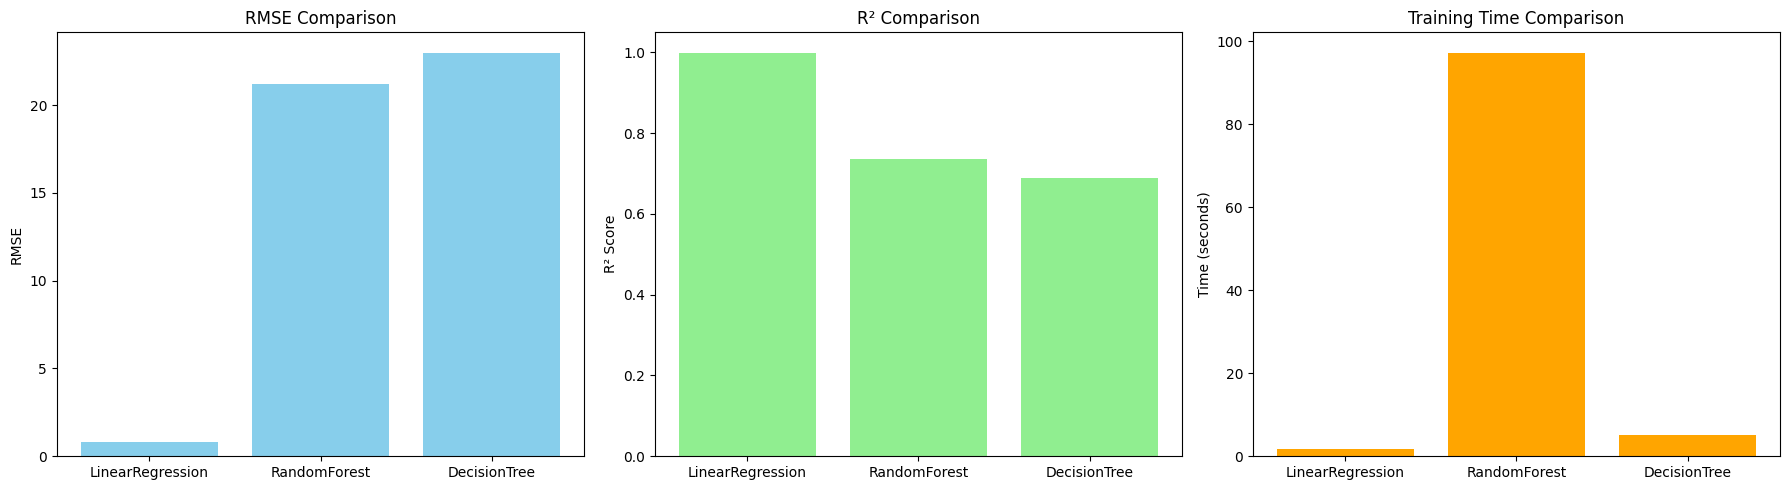

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18,5))  # 1 صف × 3 أعمدة

# ====== RMSE ======
axs[0].bar(results_df["Model"], results_df["RMSE"], color="skyblue")
axs[0].set_title("RMSE Comparison")
axs[0].set_ylabel("RMSE")

# ====== R² ======
axs[1].bar(results_df["Model"], results_df["R2"], color="lightgreen")
axs[1].set_title("R² Comparison")
axs[1].set_ylabel("R² Score")

# ====== Time ======
axs[2].bar(results_df["Model"], results_df["Time_s"], color="orange")
axs[2].set_title("Training Time Comparison")
axs[2].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()


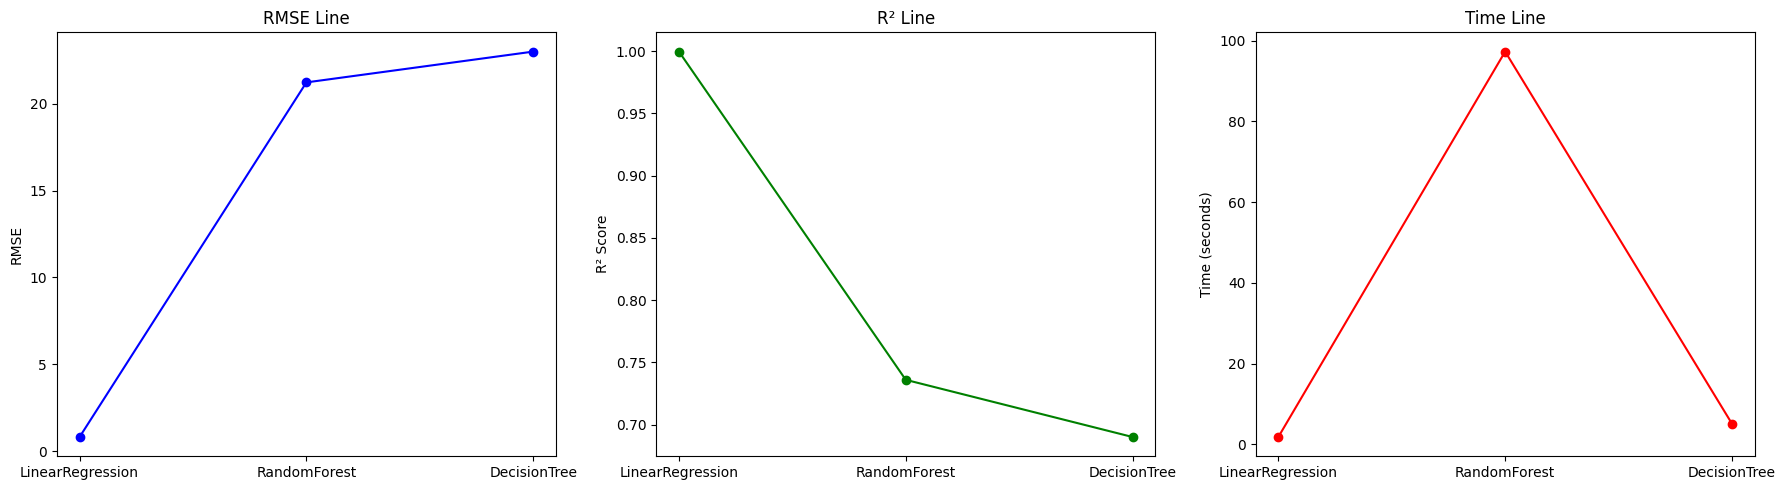

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))  # 1 صف × 3 أعمدة

# ====== RMSE ======
axs[0].plot(results_df["Model"], results_df["RMSE"], marker="o", color="blue")
axs[0].set_title("RMSE Line")
axs[0].set_ylabel("RMSE")

# ====== R² ======
axs[1].plot(results_df["Model"], results_df["R2"], marker="o", color="green")
axs[1].set_title("R² Line")
axs[1].set_ylabel("R² Score")

# ====== Time ======
axs[2].plot(results_df["Model"], results_df["Time_s"], marker="o", color="red")
axs[2].set_title("Time Line")
axs[2].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()


In [31]:
import time
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor

e_rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
e_r2   = RegressionEvaluator(metricName="r2",   labelCol="label", predictionCol="prediction")

def run_model(model_name, model_obj, train_df, test_df):
    t0 = time.time()
    mdl = model_obj.fit(train_df)
    preds = mdl.transform(test_df)
    dur = time.time() - t0
    return {
        "Model": model_name,
        "RMSE": float(e_rmse.evaluate(preds)),
        "R2":   float(e_r2.evaluate(preds)),
        "Time_s": dur
    }

def experiment(sample_frac=1.0, partitions=None, seed=42):
    #  (للمقارنة بالحجم)
    tr = train_v.sample(withReplacement=False, fraction=sample_frac, seed=seed) if sample_frac<1 else train_v
    te = test_v.sample(withReplacement=False,  fraction=sample_frac, seed=seed) if sample_frac<1 else test_v

    # إعادة تقسيم (للمقارنة بالـ partitions)
    if partitions:
        tr = tr.repartition(partitions).cache(); tr.count()
        te = te.repartition(partitions).cache(); te.count()

    results = []
    results.append(run_model("LinearRegression",
                             LinearRegression(featuresCol="features", labelCol="label"),
                             tr, te))
    results.append(run_model("DecisionTree",
                             DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=12, seed=seed),
                             tr, te))
    results.append(run_model("RandomForest",
                             RandomForestRegressor(featuresCol="features", labelCol="label",
                                                   numTrees=200, maxDepth=12, subsamplingRate=0.8, seed=seed),
                             tr, te))
    # معلومات التجربة
    for r in results:
        r["SampleFrac"] = sample_frac
        r["Partitions"] = partitions if partitions else "default"
        r["RowsTrain"]  = tr.count()
        r["RowsTest"]   = te.count()
    return results


In [32]:
base_par = spark.sparkContext.defaultParallelism
scenarios = [
    (0.25, None),
    (0.50, None),
    (1.00, None),
    (1.00, base_par*2),
    (1.00, base_par*4),
]

all_results = []
for frac, parts in scenarios:
    all_results += experiment(sample_frac=frac, partitions=parts)

import pandas as pd
res_df = pd.DataFrame(all_results)

# حساب Speedup داخل كل موديل بالنسبة لزمن الحالة الأساسية (full data + default partitions)
def compute_speedup(df):
    df = df.copy()
    # خط أساس لكل موديل
    base = df[(df["SampleFrac"]==1.0) & (df["Partitions"]=="default")][["Model","Time_s"]].set_index("Model")["Time_s"].to_dict()
    df["Speedup_vsFullDefault"] = df.apply(lambda r: base[r["Model"]]/r["Time_s"] if r["Model"] in base else None, axis=1)
    return df

res_df = compute_speedup(res_df)
res_df.sort_values(["Model","SampleFrac","Partitions"]).reset_index(drop=True)


,Model,RMSE,R2,Time_s,SampleFrac,Partitions,RowsTrain,RowsTest,Speedup_vsFullDefault
0,DecisionTree,2.111139e+01,0.742034,4.735555,0.25,default,4140,1040,0.893656
1,DecisionTree,2.027167e+01,0.755603,4.484558,0.50,default,8183,2055,0.943673
2,DecisionTree,2.137693e+01,0.732088,4.763252,1.00,4,16143,4033,0.888460
3,DecisionTree,2.077907e+01,0.746864,6.309149,1.00,8,16143,4033,0.670765
4,DecisionTree,2.123808e+01,0.735557,4.231958,1.00,default,16143,4033,1.000000
5,LinearRegression,6.154954e-12,1.000000,2.032670,0.25,default,4140,1040,0.452553
6,LinearRegression,2.155297e-14,1.000000,1.552687,0.50,default,8183,2055,0.592450
7,LinearRegression,3.158756e-12,1.000000,1.780848,1.00,4,16143,4033,0.516546
8,LinearRegression,1.704639e-14,1.000000,0.923328,1.00,8,16143,4033,0.996277
9,LinearRegression,1.570205e-11,1.000000,0.919890,1.00,default,16143,4033,1.000000


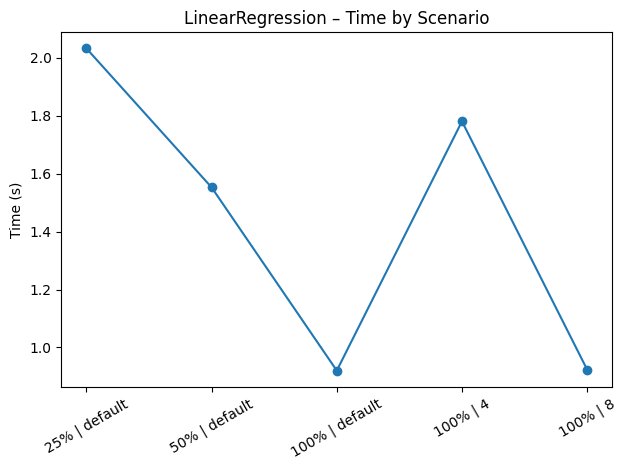

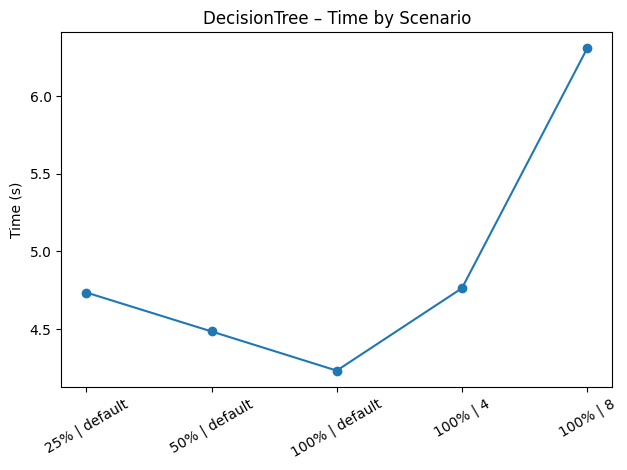

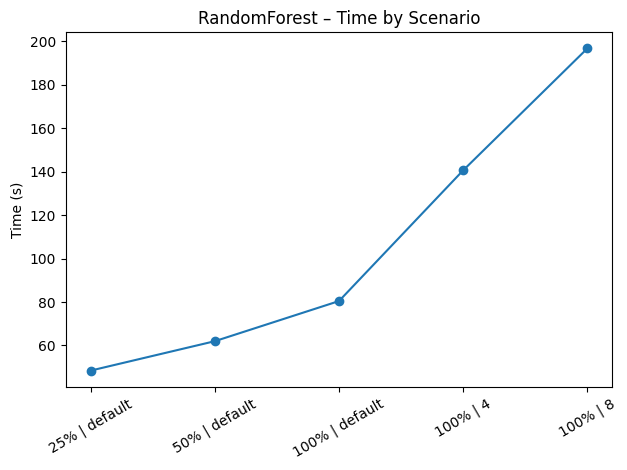

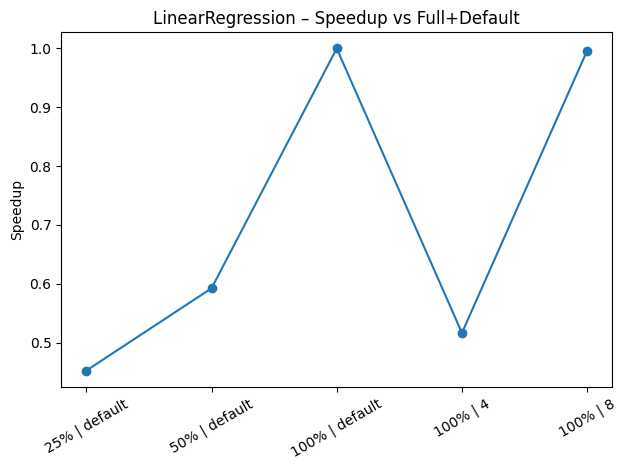

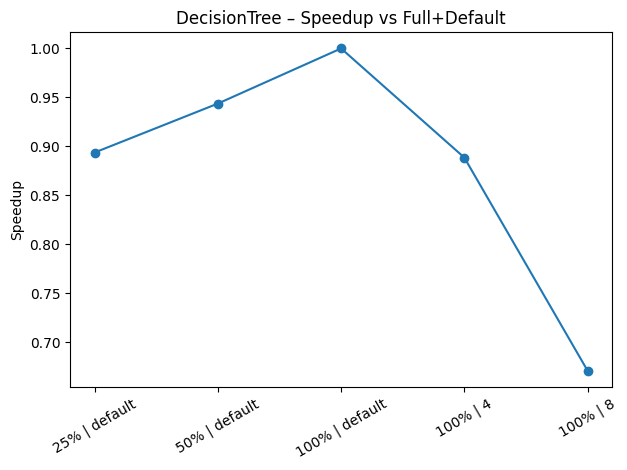

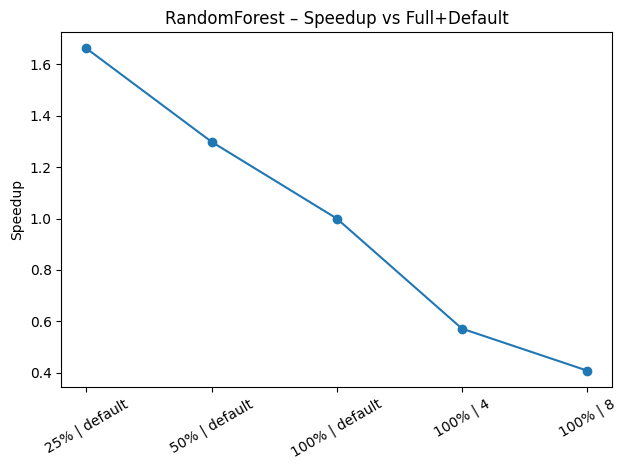

In [33]:
import matplotlib.pyplot as plt

for m in res_df["Model"].unique():
    sub = res_df[res_df["Model"]==m]
    plt.figure()
    plt.title(f"{m} – Time by Scenario")
    plt.plot(range(len(sub)), sub["Time_s"], marker="o")
    plt.xticks(range(len(sub)), [f'{f*100:.0f}% | {p}' for f,p in zip(sub["SampleFrac"], sub["Partitions"])], rotation=30)
    plt.ylabel("Time (s)")
    plt.tight_layout()
    plt.show()

# مخطط للـ Speedup
for m in res_df["Model"].unique():
    sub = res_df[res_df["Model"]==m]
    plt.figure()
    plt.title(f"{m} – Speedup vs Full+Default")
    plt.plot(range(len(sub)), sub["Speedup_vsFullDefault"], marker="o")
    plt.xticks(range(len(sub)), [f'{f*100:.0f}% | {p}' for f,p in zip(sub["SampleFrac"], sub["Partitions"])], rotation=30)
    plt.ylabel("Speedup")
    plt.tight_layout()
    plt.show()


In [38]:
# ثبّت نتائج السبارك باسم واضح
spark_results_df = results_df.copy()

# للتأكد ان الأعمدة موجودة وبأنواع رقمية
need = ["Model","RMSE","R2","Time_s"]
assert all(c in spark_results_df.columns for c in need), spark_results_df.columns
for c in ["RMSE","R2","Time_s"]:
    spark_results_df[c] = pd.to_numeric(spark_results_df[c], errors="coerce")
spark_results_df


,Model,Time_s,RMSE,R2
0,LinearRegression,1.840943,0.820255,0.999606
1,DecisionTree,5.135209,22.995851,0.689972
2,RandomForest,97.309079,21.224103,0.735905


In [40]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, os

SCIKIT_CSV = "/content/drive/MyDrive/AmazonData/results/results_sklearn_experiments.csv"
scikit_df = pd.read_csv(SCIKIT_CSV)

# التأكد من الأعمدة
want = ["Model","RMSE","R2","Time_s"]
scikit_df = scikit_df[want]
for c in ["RMSE","R2","Time_s"]:
    scikit_df[c] = pd.to_numeric(scikit_df[c], errors="coerce")
scikit_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Model,RMSE,R2,Time_s
0,LinearRegression+Scaled,0.426195,0.941232,0.001504
1,DecisionTree,1.774311,-0.018550,0.038281
2,RandomForest,1.712169,0.051547,6.234854
3,LinearRegression+Scaled,0.841523,0.983833,0.005129
4,DecisionTree,7.683853,-0.347932,0.119578


In [41]:
spark_results_df["Model"] = spark_results_df["Model"].replace({
    "LinearRegression": "LinearRegression"  # أو "LinearRegression+Scaled"
})


In [42]:
scikit_df["Env"] = "Scikit-learn"
spark_results_df["Env"] = "Spark"

compare_df = pd.concat([scikit_df, spark_results_df], ignore_index=True)
compare_df


,Model,RMSE,R2,Time_s,Env
0,LinearRegression+Scaled,0.426195,0.941232,0.001504,Scikit-learn
1,DecisionTree,1.774311,-0.018550,0.038281,Scikit-learn
2,RandomForest,1.712169,0.051547,6.234854,Scikit-learn
3,LinearRegression+Scaled,0.841523,0.983833,0.005129,Scikit-learn
4,DecisionTree,7.683853,-0.347932,0.119578,Scikit-learn
5,RandomForest,7.670719,-0.343328,5.324588,Scikit-learn
6,LinearRegression+Scaled,5.564525,0.980779,0.002519,Scikit-learn
7,DecisionTree,17.884472,0.801452,0.116987,Scikit-learn
8,RandomForest,17.411669,0.811811,14.687505,Scikit-learn
9,LinearRegression+Scaled,5.564525,0.980779,0.003533,Scikit-learn


In [43]:
import os
RESULTS_DIR = "/content/drive/MyDrive/AmazonData/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

scikit_df.to_csv(os.path.join(RESULTS_DIR, "scikit_results.csv"), index=False)
spark_results_df.to_csv(os.path.join(RESULTS_DIR, "spark_results.csv"), index=False)
compare_df.to_csv(os.path.join(RESULTS_DIR, "compare_results.csv"), index=False)

print("✅ Saved:", RESULTS_DIR)


✅ Saved: /content/drive/MyDrive/AmazonData/model_results


/tmp/ipython-input-235860416.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  compare_df.pivot_table(index="Model", columns="Env", values="RMSE", aggfunc="mean").plot(
/tmp/ipython-input-235860416.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  compare_df.pivot_table(index="Model", columns="Env", values="R2", aggfunc="mean").plot(
/tmp/ipython-input-235860416.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  compare_df.pivot_table(index="Model", columns="Env", values="Time_s", aggfunc="mean").

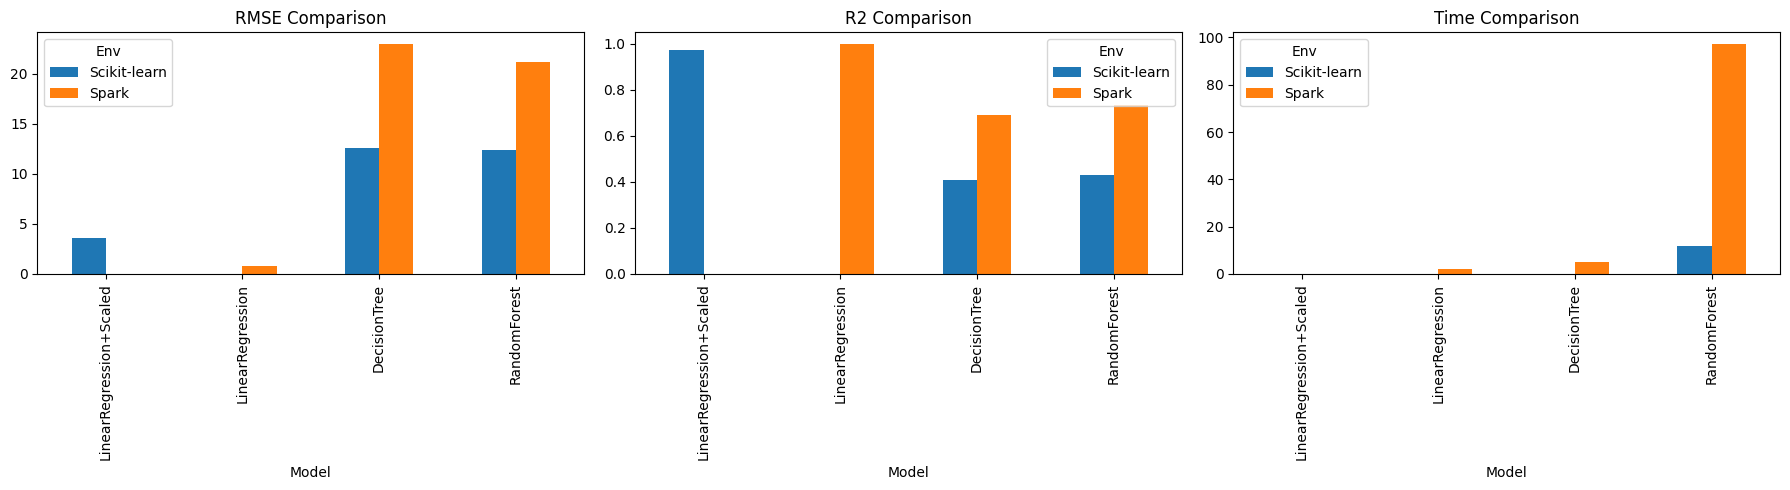

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1) RMSE
compare_df.pivot_table(index="Model", columns="Env", values="RMSE", aggfunc="mean").plot(
    kind="bar", ax=axs[0], title="RMSE Comparison"
)

# 2) R2
compare_df.pivot_table(index="Model", columns="Env", values="R2", aggfunc="mean").plot(
    kind="bar", ax=axs[1], title="R2 Comparison"
)

# 3) Time
compare_df.pivot_table(index="Model", columns="Env", values="Time_s", aggfunc="mean").plot(
    kind="bar", ax=axs[2], title="Time Comparison"
)

plt.tight_layout()
plt.show()


In [56]:
# [Cell 4A] merge when results_df (scikit) موجود
scikit_df = results_df.copy()


In [57]:
# [Cell 4C] unify shape and add Env column
scikit_df["Env"] = "Scikit-learn"
spark_df = spark_results_df.copy()
spark_df["Env"] = "Spark"

# لو في أعمدة إضافية في scikit_df مش موجودة في spark_df، خلّي الأعمدة المشتركة
common_cols = [c for c in ["Model", "RMSE", "R2", "Time_s", "Env"] if c in scikit_df.columns and c in spark_df.columns]
compare_df = pd.concat([scikit_df[common_cols], spark_df[common_cols]], ignore_index=True)
compare_df


,Model,RMSE,R2,Time_s,Env
0,LinearRegression,0.820255,0.999606,1.840943,Scikit-learn
1,DecisionTree,22.995851,0.689972,5.135209,Scikit-learn
2,RandomForest,21.224103,0.735905,97.309079,Scikit-learn
3,LinearRegression,0.820255,0.999606,0.561685,Spark
4,DecisionTree,22.995851,0.689972,4.124545,Spark
5,RandomForest,21.224103,0.735905,101.613020,Spark
